In [1]:
import geopandas as gpd
import pandas as pd

import mapillary as mly

import glob

from datetime import datetime



### osm-netzwerk einlesen

In [6]:
#set_date = "251010" 
#set_date = "251022" 
#set_date = "251115" 
set_date = "251215" 


cycleways=gpd.read_parquet(f"processed_osm_files/processed_cycleways_germany_{set_date}.parquet")
motorways=gpd.read_parquet(f"processed_osm_files/processed_motorways_germany_{set_date}.parquet")

print("number of cycleways:", len(cycleways))
print("number of motorways:", len(motorways))

number of cycleways: 5501329
number of motorways: 70011


In [7]:
cycleways.head()

,osm_id,highway,bicycle,bicycle_forward,bicycle_backward,cycleway,cycleway_left,cycleway_right,cycleway_both,cycleway_lane,...,maxspeed,maxspeed_conditional,maxspeed_backward,maxspeed_forward,maxspeed_type,name,ref,surface,width,geometry
0,99,tertiary,None,None,None,None,None,no,None,None,...,None,None,None,None,None,None,None,asphalt,None,"LINESTRING (11.36639 48.17411, 11.36643 48.174..."
1,104,unclassified,None,None,None,None,None,None,no,None,...,50,None,None,None,None,Münzmeisterstraße,None,asphalt,None,"LINESTRING (13.74142 51.02366, 13.74139 51.023..."
2,105,residential,None,None,None,None,None,None,no,None,...,30,None,None,None,None,Altpestitz,None,sett,None,"LINESTRING (13.73698 51.01663, 13.73643 51.016..."
3,107,residential,None,None,None,None,None,None,no,None,...,30,None,None,None,None,Trienter Straße,None,asphalt,None,"LINESTRING (13.73507 51.01914, 13.73505 51.019..."
4,110,residential,None,None,None,None,None,None,no,None,...,50,None,None,None,sign,Heinrich-Greif-Straße,None,concrete:plates,None,"LINESTRING (13.74296 51.02871, 13.74295 51.028..."


In [8]:
cycleways.columns

Index(['osm_id', 'highway', 'bicycle', 'bicycle_forward', 'bicycle_backward',
       'cycleway', 'cycleway_left', 'cycleway_right', 'cycleway_both',
       'cycleway_lane', 'cycleway_track', 'cycleway_opposite',
       'cycleway_shared_lane', 'sidewalk_right_bicycle',
       'sidewalk_left_bicycle', 'sidewalk_both_bicycle', 'maxspeed',
       'maxspeed_conditional', 'maxspeed_backward', 'maxspeed_forward',
       'maxspeed_type', 'name', 'ref', 'surface', 'width', 'geometry'],
      dtype='object')

In [9]:
filtered_cycleways = cycleways[
    (cycleways["bicycle"].isin(["designated"])) |
    (cycleways["bicycle_backward"].isin(["designated"])) |
    (cycleways["bicycle_forward"].isin(["designated"])) |
    (cycleways["highway"].isin(["cycleway"])) |
    (cycleways["cycleway"].notnull() & (cycleways["cycleway"] != "no")) |
    (cycleways["cycleway_left"].notnull() & (cycleways["cycleway_left"] != "no")) |
    (cycleways["cycleway_right"].notnull() & (cycleways["cycleway_right"] != "no")) |
    (cycleways["cycleway_both"].notnull() & (cycleways["cycleway_both"] != "no")) |
    (cycleways["cycleway_lane"].notnull() & (cycleways["cycleway_lane"] != "no")) |
    (cycleways["cycleway_track"].notnull() & (cycleways["cycleway_track"] != "no")) |
    # (cycleways["sidewalk_bicycle"].isin(["designated"])) |  TODO: add "sidewalk:bicycle" in ini file
    (cycleways["sidewalk_right_bicycle"].isin(["designated"])) |
    (cycleways["sidewalk_left_bicycle"].isin(["designated"])) |
    (cycleways["sidewalk_both_bicycle"].isin(["designated"])) 
]
len(filtered_cycleways)

775820

In [10]:
#filtered_cycleways[::10].plot()

In [11]:
# # Lade lk
# lk = gpd.read_file("https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/refs/heads/main/4_kreise/1_sehr_hoch.geo.json")
# #lk[lk.NAME_3 == "Ravensburg"].plot()

# sel_lk = lk[lk.NAME_3 == "Berlin"]
# sel_lk=sel_lk.to_crs(filtered_cycleways.crs)
# filtered_cycleways_lk = filtered_cycleways.clip(sel_lk)

# filtered_cycleways_lk.plot()

In [12]:
#motorways.plot()

In [13]:
filtered_cycleways_proj = filtered_cycleways.to_crs(25833)
filtered_cycleways_proj["length_m"] = filtered_cycleways_proj.geometry.length
#filtered_cycleways_proj[["osm_id", "length_m"]]

total_km = filtered_cycleways_proj.length_m.sum() / 1000
print(f"Gesamtlänge der gefilterten 'Radinfra': {total_km:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".") + " km")

Gesamtlänge der gefilterten 'Radinfra': 138.778,57 km


In [14]:
#filtered_cycleways.highway.value_counts()

### mapillary traffic signs einlesen

In [ ]:


## TRAFFFIC SIGNS
# https://www.mapillary.com/developer/api-documentation/traffic-signs?locale=


### EINLESEN

# Find all parquet files in the tile_cache folder (per state)
parquet_files = glob.glob("../../output/mapillary_traffic-signs_*.parquet")
# Extract and print the dates from the filenames
dates = [f.split("_")[-1].replace(".parquet", "") for f in parquet_files]
# Drop all duplicates in the list
dates = list(set(dates))
print("Dates found in filenames:", dates)
# Read all files and concatenate into one GeoDataFrame
mapillary_trafficsigns = gpd.GeoDataFrame(
    pd.concat([gpd.read_parquet(f) for f in parquet_files], ignore_index=True),
    crs=gpd.read_parquet(parquet_files[0]).crs
)




### FILTERN

# Unterschiedliche Verkehrszeichen in Deutschland für Radwege

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:237
# Radweg
de_237="regulatory--bicycles-only--g1"

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:240
# Gemeinsamer Geh- und Radweg
de_240="regulatory--shared-path-pedestrians-and-bicycles--g1"

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:241-30
# Getrennter Rad- und Gehweg
de_241_30="regulatory--dual-path-bicycles-and-pedestrians--g1"

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:241-31
# Getrennter Rad- und Gehweg
de_241_31="regulatory--dual-path-pedestrians-and-bicycles--g1"


# ggf. noch  "complementary--except-bicycles--g1" https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:1022-10

# 2025-06-07 ## -> 184120 features
# 2025-07-30 ## -> 213732 features
# 2025-08-05 ## -> 214438 features
# 2025-09-08 ## -> 220510 features
# 2025-10-29 ## -> 224575 features
# 2025-11-15 ## -> 225871 features
# 2025-11-15 ## -> 233358 features

# filter to cw only
mapillary_trafficsigns_cw=mapillary_trafficsigns[mapillary_trafficsigns.value.isin([de_237, de_240, de_241_30, de_241_31])]
# drop duplicates if any
mapillary_trafficsigns_cw=mapillary_trafficsigns_cw.drop_duplicates(subset=['id'])

mapillary_trafficsigns_cw




Dates found in filenames: ['2025-12-12']


,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y
88,POINT (8.15822 48.97415),2017-05-25,284359993394671,2019-12-28,regulatory--bicycles-only--g1,8563,5628
96,POINT (8.16859 48.97427),2017-05-25,308496147329522,2019-12-28,regulatory--bicycles-only--g1,8563,5628
101,POINT (8.17277 48.97546),2019-12-28,953606608728218,2019-12-28,regulatory--bicycles-only--g1,8563,5628
153,POINT (8.15724 48.97421),2017-05-25,305221827781685,2017-05-25,regulatory--bicycles-only--g1,8563,5628
157,POINT (8.15822 48.97378),2017-05-25,305273144443220,2017-05-25,regulatory--bicycles-only--g1,8563,5628
...,...,...,...,...,...,...,...
6565006,POINT (10.37143 48.6796),2023-03-13,197895492864995,2023-03-13,regulatory--shared-path-pedestrians-and-bicycl...,8664,5648
6565016,POINT (10.40746 48.98311),2025-06-16,3228059774016849,2025-06-16,regulatory--shared-path-pedestrians-and-bicycl...,8665,5627
6565168,POINT (10.40792 48.75501),2022-08-27,779372473108808,2022-08-27,regulatory--shared-path-pedestrians-and-bicycl...,8665,5643
6565237,POINT (10.45498 48.88957),2025-04-12,1173301594120527,2025-04-12,regulatory--shared-path-pedestrians-and-bicycl...,8667,5634


<Axes: xlabel='last_seen_at'>

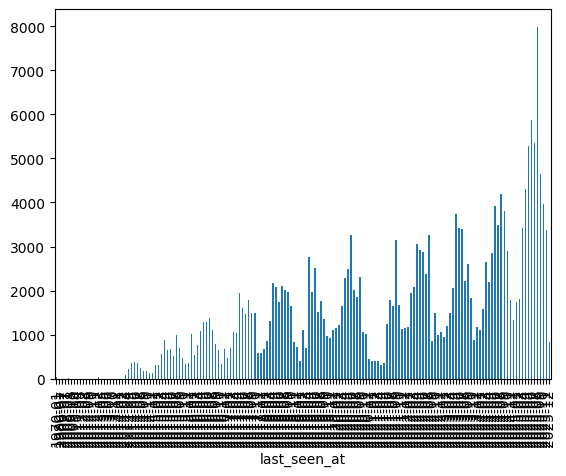

In [17]:
mapillary_trafficsigns_cw.last_seen_at.str[:-3].value_counts().sort_index().plot(kind="bar")


#### Zeitfilter 

In [19]:
##  is newer than 2025-01-01  

# september 2025: 36488
# oktober   2025: 41263
# november  2025: 45075
# dezember  2025: 48574


mapillary_trafficsigns_cw=mapillary_trafficsigns_cw[mapillary_trafficsigns_cw["last_seen_at"] > "2025-01-01"]
# mapillary_trafficsigns_237_recent
len(mapillary_trafficsigns_cw)

48574

In [20]:
mapillary_trafficsigns_cw

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y
1029,POINT (8.29359 49.06277),2025-05-19,4269712496648656,2025-05-19,regulatory--shared-path-pedestrians-and-bicycl...,8569,5622
1225,POINT (8.29802 49.03794),2020-06-01,917747055729430,2025-04-06,regulatory--shared-path-pedestrians-and-bicycl...,8569,5623
1577,POINT (8.29847 49.03735),2024-08-16,2074693739658902,2025-04-06,regulatory--dual-path-pedestrians-and-bicycles...,8569,5624
1578,POINT (8.29846 49.03735),2023-06-09,4748846525239541,2025-04-06,regulatory--shared-path-pedestrians-and-bicycl...,8569,5624
1580,POINT (8.29781 49.03716),2024-08-16,2317033441995922,2025-04-06,regulatory--shared-path-pedestrians-and-bicycl...,8569,5624
...,...,...,...,...,...,...,...
6564891,POINT (10.38334 48.84364),2025-03-07,879377904235212,2025-03-07,regulatory--shared-path-pedestrians-and-bicycl...,8664,5637
6564900,POINT (10.37156 48.84914),2025-03-07,555292337567079,2025-03-07,regulatory--shared-path-pedestrians-and-bicycl...,8664,5637
6565016,POINT (10.40746 48.98311),2025-06-16,3228059774016849,2025-06-16,regulatory--shared-path-pedestrians-and-bicycl...,8665,5627
6565237,POINT (10.45498 48.88957),2025-04-12,1173301594120527,2025-04-12,regulatory--shared-path-pedestrians-and-bicycl...,8667,5634


<Axes: xlabel='last_seen_at'>

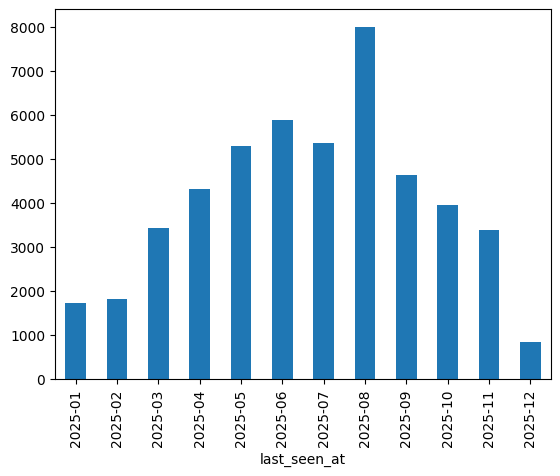

In [21]:
mapillary_trafficsigns_cw.last_seen_at.str[:-3].value_counts().sort_index().plot(kind="bar")


In [22]:
##  at least 12 months between first and last seen (to avoid temporary signs)
## might need to adjust this


zeitspanne = 9

def months_between(date1, date2):
    d1 = datetime.strptime(date1, "%Y-%m-%d")
    d2 = datetime.strptime(date2, "%Y-%m-%d")
    return abs((d2.year - d1.year) * 12 + d2.month - d1.month)

mapillary_trafficsigns_cw_temp = mapillary_trafficsigns_cw[
    mapillary_trafficsigns_cw.apply(lambda row: months_between(row['first_seen_at'], row['last_seen_at']) >= zeitspanne, axis=1)
]
len(mapillary_trafficsigns_cw_temp)

19083

<Axes: xlabel='last_seen_at'>

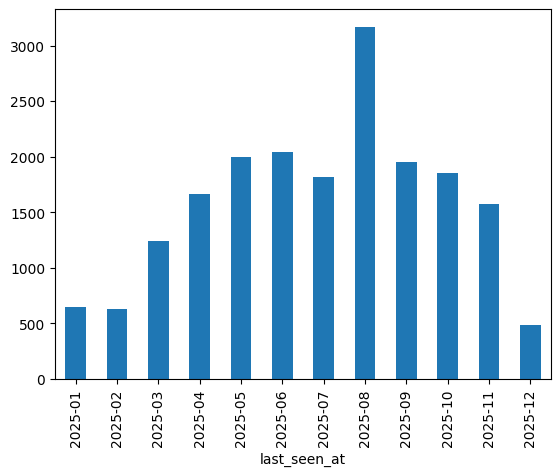

In [23]:
mapillary_trafficsigns_cw_temp.last_seen_at.str[:-3].value_counts().sort_index().plot(kind="bar")



<Axes: >

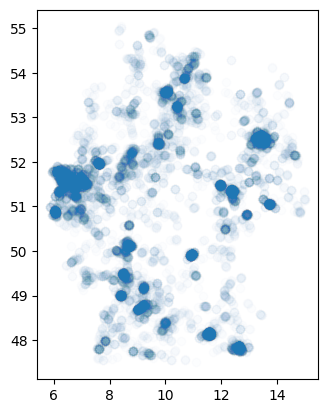

In [24]:
mapillary_trafficsigns_cw_temp.plot(alpha=0.01)

#### Räumliche Prüfung 

In [25]:
## now create a buffer around the traffic signs to check if there is a cycleway nearby
df_buffered_30 = mapillary_trafficsigns_cw_temp.to_crs(25833).copy()
df_buffered_25 = mapillary_trafficsigns_cw_temp.to_crs(25833).copy()

#df_buffered["geometry"] = df_buffered.geometry.buffer(50)
#df_buffered["geometry"] = df_buffered.geometry.buffer(40)
df_buffered_30["geometry"] = df_buffered_30.geometry.buffer(30)
df_buffered_25["geometry"] = df_buffered_25.geometry.buffer(25)


df_buffered_30 = df_buffered_30.to_crs(mapillary_trafficsigns_cw_temp.crs)
df_buffered_25 = df_buffered_25.to_crs(mapillary_trafficsigns_cw_temp.crs)


In [26]:
# helper 
def mark_intersections(buffered_df, target_layer, column_name="has_intersection"):
    """
    Marks which geometries in `buffered_df` intersect with `target_layer`.

    Parameters:
    - buffered_df (GeoDataFrame): The GeoDataFrame containing buffered geometries.
    - target_layer (GeoDataFrame): The GeoDataFrame to check for intersections (e.g., cycleways, motorways).
    - column_name (str): Name of the column to add/overwrite in `buffered_df` indicating intersection (bool).

    Returns:
    - GeoDataFrame: `buffered_df` with a new boolean column `column_name`.
    """
    # Ensure CRS matches
    buffered_df = buffered_df.to_crs(target_layer.crs)

    # Perform spatial join to find intersecting geometries
    joined = gpd.sjoin(buffered_df, target_layer, how="inner", predicate="intersects")

    # Initialize the new column to False
    buffered_df[column_name] = False

    # Set True for geometries that intersect
    matches = joined.index.unique()
    buffered_df.loc[matches, column_name] = True

    return buffered_df


In [27]:
# For cycleways
df_buffered_30 = mark_intersections(df_buffered_30, filtered_cycleways, column_name="has_cw_intersection")
df_buffered_25 = mark_intersections(df_buffered_25, filtered_cycleways, column_name="has_cw_intersection")



# For motorways (just 30m for both)
df_buffered_30 = mark_intersections(df_buffered_30, motorways, column_name="has_mw_intersection")
#df_buffered_20 = mark_intersections(df_buffered_30, motorways, column_name="has_mw_intersection")



In [28]:
df_buffered_30["buffer_size"] = 30
df_buffered_25["buffer_size"] = 25

In [29]:
#df_buffered.id.unique()

In [30]:
# An wie vielen Schilder ist ein Radweg in der Nähe?
df_buffered_30.has_cw_intersection.value_counts()

has_cw_intersection
True     18502
False      581
Name: count, dtype: int64

In [31]:
df_buffered_25.has_cw_intersection.value_counts()

has_cw_intersection
True     18476
False      607
Name: count, dtype: int64

In [32]:
# An wie vielen Schilder ist eine Autobahn in der Nähe?
df_buffered_30.has_mw_intersection.value_counts()

has_mw_intersection
False    18944
True       139
Name: count, dtype: int64

In [33]:
df_buffered_30.has_mw_intersection

1225       False
1578       False
1581       False
1586       False
3312       False
           ...  
6555522    False
6555542    False
6562279    False
6562818    False
6563397    False
Name: has_mw_intersection, Length: 19083, dtype: bool

In [34]:
df_buffered_25_false=df_buffered_25[(df_buffered_25.has_cw_intersection== False) & (df_buffered_30.has_mw_intersection== False)].copy()
len(df_buffered_25_false)

532

In [35]:
df_buffered_30_false=df_buffered_30[(df_buffered_30.has_cw_intersection== False) & (df_buffered_30.has_mw_intersection== False)].copy()
len(df_buffered_30_false)

506

In [36]:
df_buffered_25_false

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,buffer_size
185377,"POLYGON ((7.59655 50.34901, 7.59655 50.34899, ...",2015-05-21,303216431293482,2025-05-01,regulatory--bicycles-only--g1,8537,5531,False,25
187266,"POLYGON ((7.5941 50.35979, 7.5941 50.35977, 7....",2024-01-26,240698955759784,2025-08-21,regulatory--shared-path-pedestrians-and-bicycl...,8537,5530,False,25
268108,"POLYGON ((7.9907 49.42214, 7.9907 49.42212, 7....",2015-08-21,526714152040009,2025-05-08,regulatory--bicycles-only--g1,8555,5597,False,25
273265,"POLYGON ((8.06311 49.3743, 8.06311 49.37428, 8...",2018-03-24,496747558142771,2025-05-08,regulatory--bicycles-only--g1,8558,5600,False,25
299982,"POLYGON ((8.18562 49.5554, 8.18563 49.55538, 8...",2024-09-16,2677930025721628,2025-12-05,regulatory--dual-path-bicycles-and-pedestrians...,8564,5587,False,25
...,...,...,...,...,...,...,...,...,...
6483669,"POLYGON ((9.76284 49.0885, 9.76284 49.08848, 9...",2025-03-02,1554360611864567,2025-12-10,regulatory--shared-path-pedestrians-and-bicycl...,8636,5620,False,25
6499629,"POLYGON ((9.84039 48.21101, 9.84039 48.21099, ...",2020-07-12,302865191328462,2025-08-05,regulatory--shared-path-pedestrians-and-bicycl...,8639,5680,False,25
6500910,"POLYGON ((9.83031 47.67827, 9.83031 47.67825, ...",2024-08-22,2235848886773848,2025-11-10,regulatory--dual-path-pedestrians-and-bicycles...,8639,5717,False,25
6503628,"POLYGON ((9.84759 48.21192, 9.84759 48.2119, 9...",2024-09-12,1043811657474361,2025-08-05,regulatory--shared-path-pedestrians-and-bicycl...,8640,5680,False,25


In [37]:
df_buffered_both_false= pd.concat([df_buffered_30_false, df_buffered_25_false]).sort_values("buffer_size").drop_duplicates(subset=['id'],keep="last")
df_buffered_both_false["buffer_size"].value_counts()

buffer_size
30    506
25     26
Name: count, dtype: int64

priority bei MapRoulette:

| Wert | Bedeutung         |
| ---- | ----------------- |
| 0    | High              |
| 1    | Medium (Standard) |
| 2    | Low               |


In [38]:
df_buffered_both_false["prio"] = df_buffered_both_false["buffer_size"].map({25: 1, 30: 0}).astype("Int64")

In [39]:
df_buffered_both_false

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,has_mw_intersection,buffer_size,prio
1742151,"POLYGON ((13.38871 52.53296, 13.3887 52.53294,...",2022-02-21,337440064982798,2025-06-11,regulatory--bicycles-only--g1,8801,5372,False,NaN,25,1
5224353,"POLYGON ((12.97882 47.84199, 12.97882 47.84197...",2024-10-02,1643390686240585,2025-08-14,regulatory--bicycles-only--g1,8782,5706,False,NaN,25,1
4534844,"POLYGON ((10.91029 49.91445, 10.91029 49.91443...",2017-09-22,596036731790938,2025-11-23,regulatory--shared-path-pedestrians-and-bicycl...,8688,5562,False,NaN,25,1
4878212,"POLYGON ((11.62125 48.22315, 11.62125 48.22313...",2024-12-14,1518764388839119,2025-11-03,regulatory--shared-path-pedestrians-and-bicycl...,8720,5680,False,NaN,25,1
5178814,"POLYGON ((12.65481 47.81831, 12.65481 47.81829...",2023-04-01,186190040875225,2025-08-14,regulatory--shared-path-pedestrians-and-bicycl...,8767,5707,False,NaN,25,1
...,...,...,...,...,...,...,...,...,...,...,...
1739867,"POLYGON ((13.38793 52.52714, 13.38793 52.52711...",2024-11-04,364802796654682,2025-09-11,regulatory--bicycles-only--g1,8801,5372,False,False,30,0
1536225,"POLYGON ((14.84185 50.85548, 14.84185 50.85546...",2016-02-13,323209695993715,2025-05-23,regulatory--dual-path-bicycles-and-pedestrians...,8867,5495,False,False,30,0
268108,"POLYGON ((7.99077 49.42215, 7.99077 49.42212, ...",2015-08-21,526714152040009,2025-05-08,regulatory--bicycles-only--g1,8555,5597,False,False,30,0
2028449,"POLYGON ((5.89401 50.99691, 5.89402 50.99689, ...",2017-07-24,498570288002296,2025-11-04,regulatory--bicycles-only--g1,8460,5485,False,False,30,0


In [40]:
# interactive map
# df_buffered_false.explore(
#     color="red",
#     tiles="CartoDB positron",
#     popup=True,
#     tooltip=["value", "first_seen_at", "last_seen_at"]
# )

In [41]:
import json
import requests

#### clean up from existing maproulette challenge

In [42]:
### import the the flagged (not created, fixed) tasks from the challenge. 

# challenge_gdf = gpd.read_file("challenge_52916_data_f_mr.geojson")
#challenge_gdf.head()

with open("../utils/config_mapillary_privat.json", "r") as f:
    config = json.load(f)
API_KEY = config["API_KEY_MAPROULETTE"]

CHALLENGE_ID = 52916
BASE_URL = "https://maproulette.org/api/v2"

headers = {"apiKey": API_KEY}

# Single request to get all tasks as GeoJSON
r = requests.get(
    f"{BASE_URL}/challenge/view/{CHALLENGE_ID}",
    headers=headers
)
r.raise_for_status()
geojson_data = r.json()

# Convert directly to GeoDataFrame
challenge_gdf = gpd.GeoDataFrame.from_features(geojson_data, crs='EPSG:4326')

challenge_gdf=challenge_gdf[~challenge_gdf.mr_taskStatus.isin(["Fixed", "Created", "Skipped"])]

df_buffered_both_false = df_buffered_both_false.to_crs(4326)

# Find intersections
intersections = gpd.sjoin(df_buffered_both_false, challenge_gdf, how="left", predicate="intersects")

# Keep only rows that do NOT intersect (i.e., no match in challenge_gdf)
df_buffered_both_false_no_challenge = df_buffered_both_false.loc[intersections.index[intersections["index_right"].isna()]] 

len(df_buffered_both_false_no_challenge)


469

### retrieve the image ID for the map features

In [43]:
#df_process_img= df_buffered_false.copy()
df_process_img= df_buffered_both_false_no_challenge.copy()

In [44]:
import sys
import os
import json
import logging
from contextlib import contextmanager
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# ---------------------------------------------------------------


# -- suppress stdout context manager --
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# -- Load config & set Mapillary token --
with open("config_mapillary_privat.json", "r") as f:
    config = json.load(f)

access_token = config["ACCESS_TOKEN"]
mly.interface.set_access_token(access_token)

# -- Logging cleanup --
for name in logging.root.manager.loggerDict:
    logging.getLogger(name).setLevel(logging.WARNING)
logging.basicConfig(level=logging.ERROR)

# -- Your image fetching function --
def get_image_id(map_feature_id):
    try:
        feature_str = mly.interface.feature_from_key(key=str(map_feature_id))
        feature = json.loads(feature_str)
        images = feature["features"]["properties"]["images"]["data"]
        return images[-1]["id"] if images else None
    except Exception as e:
        return None  # Or log the error if needed

# -- Parallelized version using ThreadPoolExecutor --
def parallel_get_image_ids(ids, max_workers=8):
    results = [None] * len(ids)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(get_image_id, id_): idx for idx, id_ in enumerate(ids)}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Fetching image IDs"):
            idx = futures[future]
            try:
                results[idx] = future.result()
            except Exception:
                results[idx] = None  # Or log
    return results

# -- Apply to your dataframe --
with suppress_stdout():
    df_process_img["image_id"] = parallel_get_image_ids(df_process_img["id"].tolist(), max_workers=5)  # Adjust max_workers as needed, 5 is fastest for me


Fetching image IDs: 100%|██████████| 469/469 [01:34<00:00,  4.94it/s]


In [45]:
## https://www.mapillary.com/app/?pKey=1029316554880692

df_process_img.head()



,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,has_mw_intersection,buffer_size,prio,image_id
1742151,"POLYGON ((13.38871 52.53296, 13.3887 52.53294,...",2022-02-21,337440064982798,2025-06-11,regulatory--bicycles-only--g1,8801,5372,False,NaN,25,1,636323730989906
5224353,"POLYGON ((12.97882 47.84199, 12.97882 47.84197...",2024-10-02,1643390686240585,2025-08-14,regulatory--bicycles-only--g1,8782,5706,False,NaN,25,1,1293971222018177
4534844,"POLYGON ((10.91029 49.91445, 10.91029 49.91443...",2017-09-22,596036731790938,2025-11-23,regulatory--shared-path-pedestrians-and-bicycl...,8688,5562,False,NaN,25,1,752275115459349
4878212,"POLYGON ((11.62125 48.22315, 11.62125 48.22313...",2024-12-14,1518764388839119,2025-11-03,regulatory--shared-path-pedestrians-and-bicycl...,8720,5680,False,NaN,25,1,1659651871649866
3092021,"POLYGON ((7.71903 51.18555, 7.71903 51.18553, ...",2024-05-26,986734396457268,2025-05-11,regulatory--shared-path-pedestrians-and-bicycl...,8543,5471,False,NaN,25,1,451929690758666


In [46]:
# to points, to 4326

centroids = df_process_img.copy()
centroids=centroids.to_crs(25832)
centroids["geometry"] = centroids.geometry.centroid
centroids=centroids.to_crs(4326)

centroids.sort_values("last_seen_at")


,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,has_mw_intersection,buffer_size,prio,image_id
3753037,POINT (7.0094 52.25033),2021-07-15,3198411760380385,2025-01-02,regulatory--bicycles-only--g1,8511,5393,False,False,30,0,167871548620170
3752973,POINT (7.00956 52.25142),2023-05-27,2816188628512686,2025-01-02,regulatory--bicycles-only--g1,8511,5393,False,False,30,0,294157902948162
3752975,POINT (7.00985 52.25182),2023-05-27,773275031249670,2025-01-02,regulatory--bicycles-only--g1,8511,5393,False,False,30,0,733723222091489
3752976,POINT (7.00984 52.25171),2021-07-15,215615557109696,2025-01-02,regulatory--bicycles-only--g1,8511,5393,False,False,30,0,302918014849451
3752991,POINT (7.00948 52.25218),2021-07-15,132413655696549,2025-01-02,regulatory--bicycles-only--g1,8511,5393,False,False,30,0,512619183277520
...,...,...,...,...,...,...,...,...,...,...,...,...
2119002,POINT (6.10947 51.90502),2018-07-18,2915567362025722,2025-12-04,regulatory--bicycles-only--g1,8470,5418,False,False,30,0,561612431495774
299982,POINT (8.18528 49.55538),2024-09-16,2677930025721628,2025-12-05,regulatory--dual-path-bicycles-and-pedestrians...,8564,5587,False,False,30,0,539186918668295
4154777,POINT (10.34996 53.33665),2021-04-11,779892589396491,2025-12-05,regulatory--shared-path-pedestrians-and-bicycl...,8663,5311,False,False,30,0,763588710906558
2142103,POINT (6.15535 51.79117),2019-08-09,514153376446388,2025-12-07,regulatory--shared-path-pedestrians-and-bicycl...,8472,5427,False,False,30,0,299773338499184


In [47]:
# Mapping dictionary
value_to_vz = {
    'regulatory--dual-path-pedestrians-and-bicycles--g1': 241,
    'regulatory--dual-path-bicycles-and-pedestrians--g1': 241,
    'regulatory--bicycles-only--g1': 237,
    'regulatory--shared-path-pedestrians-and-bicycles--g1': 240
}

# Add new column based on mapping
centroids["VZ"] = centroids["value"].map(value_to_vz)

In [48]:
#centroids

In [49]:
centroids

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,has_mw_intersection,buffer_size,prio,image_id,VZ
1742151,POINT (13.38834 52.53295),2022-02-21,337440064982798,2025-06-11,regulatory--bicycles-only--g1,8801,5372,False,NaN,25,1,636323730989906,237
5224353,POINT (12.97849 47.84199),2024-10-02,1643390686240585,2025-08-14,regulatory--bicycles-only--g1,8782,5706,False,NaN,25,1,1293971222018177,237
4534844,POINT (10.90994 49.91444),2017-09-22,596036731790938,2025-11-23,regulatory--shared-path-pedestrians-and-bicycl...,8688,5562,False,NaN,25,1,752275115459349,240
4878212,POINT (11.62092 48.22314),2024-12-14,1518764388839119,2025-11-03,regulatory--shared-path-pedestrians-and-bicycl...,8720,5680,False,NaN,25,1,1659651871649866,240
3092021,POINT (7.71867 51.18553),2024-05-26,986734396457268,2025-05-11,regulatory--shared-path-pedestrians-and-bicycl...,8543,5471,False,NaN,25,1,451929690758666,240
...,...,...,...,...,...,...,...,...,...,...,...,...,...
383908,POINT (8.09952 50.10756),2018-09-24,295933305476601,2025-11-21,regulatory--bicycles-only--g1,8560,5548,False,False,30,0,759486761429474,237
299982,POINT (8.18528 49.55538),2024-09-16,2677930025721628,2025-12-05,regulatory--dual-path-bicycles-and-pedestrians...,8564,5587,False,False,30,0,539186918668295,241
1739867,POINT (13.38748 52.52713),2024-11-04,364802796654682,2025-09-11,regulatory--bicycles-only--g1,8801,5372,False,False,30,0,1008550447742111,237
1536225,POINT (14.84142 50.85548),2016-02-13,323209695993715,2025-05-23,regulatory--dual-path-bicycles-and-pedestrians...,8867,5495,False,False,30,0,830837524224283,241


In [50]:
centroids["prio_text"] = centroids["prio"].map({
    0: "🟩 Task mit hoher Wahrscheinlichkeit valide",
    1: "🟨 Task mit mittlerer Wahrscheinlichkeit valide",
    2: "🟥 Task mit eher geringer Wahrscheinlichkeit valide"
})

centroids[["prio", "prio_text"]].head()

,prio,prio_text
1742151,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide
5224353,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide
4534844,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide
4878212,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide
3092021,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide


In [51]:
#centroids.plot()

In [52]:
import uuid

def to_maproulette_geojson_with_links(gdf, id_field="id", name_field="value", image_field="image_id"):
    features = []

    for _, row in gdf.iterrows():
        geom = row.geometry
        centroid = geom.centroid
        lat, lon = round(centroid.y, 6), round(centroid.x, 6)

        # Optional: Mapillary image
        image_url = None
        image_id = None
        if pd.notna(row.get(image_field)):
            image_id = str(int(row[image_field]))
            image_url = (
                f"https://www.mapillary.com/app/?pKey={image_id}"
                "&focus=photo"
                "&trafficSign[]=regulatory--bicycles-only--g1"
                "&trafficSign[]=regulatory--shared-path-pedestrians-and-bicycles--g1"
                "&trafficSign[]=regulatory--dual-path-bicycles-and-pedestrians--g1"
                "&trafficSign[]=regulatory--dual-path-pedestrians-and-bicycles--g1"
            )

        # TILDA link
        tilda_url = f"https://tilda-geo.de/regionen/radinfra?map=17.4/{lat}/{lon}&config=pdqyyt.7h3d.16g9vk&v=2&data=mapillary-cycleway-traffic-signs"

#         # Build instruction
        instruction = f"""  
### 🚧 Aufgabe: Verkehrszeichen **DE:{row["VZ"]}** überprüfen und Radinfra hinzufügen
Bitte schaue dir den Bereich rund um dieses erkannte Verkehrszeichen an. Vermutlich fehlt hier eine Radinfrastruktur, die du hinzufügen kannst. Die nächste OSM-Radinfra ist mind. **{row["buffer_size"]} Meter** entfernt.

---

### 🖼️ Bild & Karte

- 📷 [**Mapillary-Bild anzeigen**]({image_url})  
(Hinweis: Das zuerst angezeigte Bild ist wahrscheinlich nicht das neueste – die neueste Aufnahme hier ist von **{row["last_seen_at"]})**

- 🗺️ [**In radinfra.de bzw TILDA ansehen**]({tilda_url})  
(Hinweis: Ist hilfreich um den aktuellen Stand der Radinfrastruktur vor Ort zu prüfen.)

---

### 📚 Nützliche Links

- 🛑 [**Traffic Sign Tool** – DE:{row["VZ"]}](https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:{row["VZ"]})  
- 🚴 [**OSM-Wiki: Radverkehrsanlagen kartieren**](https://wiki.openstreetmap.org/wiki/DE:Bicycle/Radverkehrsanlagen_kartieren)

---

Viel Erfolg beim Prüfen und Mappen! 🗺️
        """

        # Build properties
        props = {
            #"identifier": str(row[id_field]),
            "image_id": image_id,
            "Verkehrzeichen": str(row["VZ"]),
            "instruction": instruction,   #.strip(),
            "priority":  row["prio"],
            "name": row["prio_text"]
        }

        # Build feature
        feature = {
            "type": "Feature",
            "geometry": row["geometry"].__geo_interface__,
            "properties": props,
            # Set the top-level ID here
            "id":  str(row[id_field]), # detection Id
           # "priority":  row["prio"] 
        }

        # # Add Mapillary attachment if available
        # if image_id:
        #     feature["attachments"] = [
        #         {
        #             "id": str(uuid.uuid4()),
        #             "kind": "referencePhoto",
        #             "type": "mapillary",
        #             "format": "image",
        #             "data": image_id
        #         }
        #     ]

        features.append(feature)

    return {
        "type": "FeatureCollection",
        "features": features
    }


In [53]:
# Convert your df_buffered_false (or any GeoDataFrame) to GeoJSON
maproulette_geojson = to_maproulette_geojson_with_links(centroids)

# Save to file
with open("maproulette_tasks_missing-cw_instruction_vz_name_new.geojson", "w") as f:
    json.dump(maproulette_geojson, f, indent=2)


In [ ]:
### Maproulette stuff....

In [ ]:
## Add missing cycleways based on mapillary signs (Germany)


## 🚲 Fehlende Radwege anhand von Mapillary-Verkehrszeichen ergänzen (Deutschland)

Diese Challenge basiert auf automatisch erkannten, radverkehrsbezogenen Verkehrszeichen aus Mapillary-Bildern in Deutschland.

### 📌 Kriterien für jede Aufgabe

Nur Aufgaben, die **alle** folgenden Bedingungen erfüllen, wurden berücksichtigt:

- Das Verkehrszeichen wurde **in Mapillary erkannt**.
- Es handelt sich um ein **radverkehrsbezogenes Zeichen**  
  *(z. B. gemeinsamer Geh- und Radweg, reiner Radweg, getrennter Geh-/Radweg)*.
- Das Zeichen wurde **mindestens 12 Monate lang regelmäßig gesehen**.
- Die neuste Aufnahme stammt **aus dem Jahr 2025**.
- Es existiert **kein OSM-"Radweg" innerhalb von 30 m** des Standortes.

---

### 🔍 Was du tun solltest

1. Öffne den Ort in **Mapillary** und **radinfra.de** sowie einem Editor.
2. Prüfe, ob an der Stelle eine **Radinfrastruktur fehlt**.
3. Falls ja, ergänze die passenden OSM-Tags:  
   z. B. `highway=cycleway`, `cycleway=*`, `bicycle=designated`, etc.
4. Wenn bereits alles korrekt gemappt ist, kannst du die Aufgabe einfach **als erledigt markieren**.

---

🗺️ Vielen Dank für deine Hilfe beim Ausbau der Radinfrastruktur in OSM!

In [ ]:
'''
{{instruction}}
                                                                                             .
'''